
# 05_lesiones.ipynb — Análisis de Lesiones (Chivas‑ML)

**Objetivo:** Analizar lesiones por músculo/tejido/lado, línea temporal e indicadores por jugador; cruzar con **cargas previas** (7/14/21 días) y **rendimiento** previo para generar insights accionables.




In [1]:

# --- Configuración ---
from pathlib import Path
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textwrap import dedent


plt.rcParams.update({
    "figure.figsize": (10, 5),
    "axes.grid": True
})

# Ruta a la base de datos (ajustar a tu entorno)
# DB_PATH = Path(r'C:\\Users\\Nico\\Desktop\\DATA SCIENCE\\PP- VOLUNTAREADO\\chivas-ml\\data\\external\\chivas_dw.sqlite')
DB_PATH = Path(r'C:\\Users\\Nico\\Desktop\\DATA SCIENCE\\PP- VOLUNTAREADO\\chivas-ml\\data\\external\\chivas_dw.sqlite')

conn = sqlite3.connect(str(DB_PATH))


In [26]:

# --- Carga de tablas relevantes ---
df_les = pd.read_sql('SELECT * FROM DB_Lesiones', conn)
df_ent = pd.read_sql('SELECT * FROM DB_Entrenamientos', conn)
df_par = pd.read_sql('SELECT * FROM DB_Partidos', conn)
df_jug = pd.read_sql('SELECT * FROM DB_Jugadores', conn)

# Normalización básica de columnas
for df in (df_les, df_ent, df_par, df_jug):
    if 'Fecha' in df.columns:
        df['Fecha'] = pd.to_datetime(df['Fecha'], errors='coerce')
    for c in df.columns:
        if df[c].dtype == 'object':
            df[c] = df[c].astype(str).str.strip()

# Lesiones: asegurar fechas y tipo
for c in ['Fecha_inicio', 'Fecha_fin']:
    if c in df_les.columns:
        df_les[c] = pd.to_datetime(df_les[c], errors='coerce')

# Tipos de id
for _df in (df_les, df_ent, df_par, df_jug):
    if 'id_jugador' in _df.columns:
        _df['id_jugador'] = pd.to_numeric(_df['id_jugador'], errors='coerce').astype('Int64')

# Unir nombres/posición
cols_j = [c for c in ['id_jugador','Nombre','Linea'] if c in df_jug.columns]
df_les = df_les.merge(df_jug[cols_j], on='id_jugador', how='left')
df_par = df_par.merge(df_jug[cols_j], on='id_jugador', how='left')


# Definí el orden que querés
column_order = [
    "Nombre", "Linea", "Fecha_inicio", "Tipo_lesion", "Musculo", "Lado",
    "Tejido", "Fuente"
]

# Reordenar (y mantener las que no estén en column_order al final)
df_les = df_les[[col for col in column_order if col in df_les.columns] + 
                  [c for c in df_les.columns if c not in column_order]]



df_les


,Nombre,Linea,Fecha_inicio,Tipo_lesion,Musculo,Lado,Tejido,Fuente,id_lesion,id_jugador
0,Luis Olivas,Defensa Central,2025-06-11,Lesión muscular,Cuádriceps,Derecho,Miotendinosa,Equipo AP25,1,8
1,Javier Hernández,Delantera,2025-06-20,Lesión muscular,Muslo posterior,Izquierdo,Miotendinosa,Equipo AP25,2,24
2,Richard Ledezma,Extremo,2025-06-25,Sobracarga,Muslo posterior,Derecho,Muscular,Equipo AP25,3,21
3,Diego Campillo,Defensa Central,2025-07-03,Sobrecarga,Muslo posterior,Izquierdo,Muscular,Equipo AP25,4,9
4,Miguel Tapias,Defensa Central,2025-07-05,Lesión muscular,Muslo posterior,Izquierdo,Miotendinosa,Equipo AP25,5,6
5,Javier Hernández,Delantera,2025-07-19,Lesión muscular,Sóleo,Izquierdo,Miotendinosa,Equipo AP25,6,24
6,Omar Govea,Medio Defensivo,2025-07-30,Lesión muscular,Muslo posterior,Derecho,Tendinosa,Equipo AP25,7,14
7,Erick Gutiérrez,Medio Defensivo,2025-08-01,lesión muscular,Muslo posterior,Derecho,Miofascial,Equipo AP25,8,17
8,Richard Ledezma,Extremo,2025-08-03,Lesión muscular,Cuádriceps,Ambos,Intramuscular,Equipo AP25,9,21
9,José Castillo,Defensa Central,2025-08-16,Lesión muscular,Sóleo,Derecho,Miotendinosa,Equipo AP25,10,10


In [3]:

# --- Normalización de texto (mayúsculas/minúsculas y variantes) ---
def norm(s: pd.Series):
    return s.astype(str).str.strip().str.lower().str.replace('\s+', ' ', regex=True)

map_tipo = {
    'lesión muscular': 'Lesión muscular',
    'lesion muscular': 'Lesión muscular',
    'sobrecarga': 'Sobrecarga',
}
map_tejido = {
    'muscular': 'Muscular',
    'miotendinosa': 'Miotendinosa',
    'tendinosa': 'Tendinosa',
    'miofascial': 'Miofascial',
    'intramuscular': 'Intramuscular',
}

for col, mapping in [('Tipo_lesion', map_tipo), ('Tejido', map_tejido), ('Musculo', {}), ('Lado', {})]:
    if col in df_les.columns:
        low = norm(df_les[col])
        df_les[col] = low.map(lambda x: mapping.get(x, x.title()))
        
df_les.head()


<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Nico\AppData\Local\Temp\ipykernel_16276\221746211.py:3: SyntaxWarning: invalid escape sequence '\s'
  return s.astype(str).str.strip().str.lower().str.replace('\s+', ' ', regex=True)


,Nombre,Linea,Fecha_inicio,Tipo_lesion,Musculo,Lado,Tejido,Fuente,id_lesion,id_jugador
0,Luis Olivas,Defensa Central,2025-06-11,Lesión muscular,Cuádriceps,Derecho,Miotendinosa,Equipo AP25,1,8
1,Javier Hernández,Delantera,2025-06-20,Lesión muscular,Muslo Posterior,Izquierdo,Miotendinosa,Equipo AP25,2,24
2,Richard Ledezma,Extremo,2025-06-25,Sobracarga,Muslo Posterior,Derecho,Muscular,Equipo AP25,3,21
3,Diego Campillo,Defensa Central,2025-07-03,Sobrecarga,Muslo Posterior,Izquierdo,Muscular,Equipo AP25,4,9
4,Miguel Tapias,Defensa Central,2025-07-05,Lesión muscular,Muslo Posterior,Izquierdo,Miotendinosa,Equipo AP25,5,6


In [4]:

# --- Derivados útiles ---
# Duración estimada si existe Fecha_fin
if 'Fecha_fin' in df_les.columns:
    df_les['duracion_dias'] = (df_les['Fecha_fin'] - df_les['Fecha_inicio']).dt.days

# Incidencia temporal (por semana)
df_les['semana'] = df_les['Fecha_inicio'].dt.to_period('W').astype(str)
df_les['mes'] = df_les['Fecha_inicio'].dt.to_period('M').astype(str)

# Reincidencias por jugador
reinc = (df_les.sort_values(['id_jugador','Fecha_inicio'])
               .groupby('id_jugador')['Fecha_inicio']
               .diff().dt.days)
df_les['dias_desde_lesion_previa'] = reinc

df_les[['id_jugador','Nombre','Fecha_inicio','Tipo_lesion','Musculo','Lado','Tejido','dias_desde_lesion_previa']].head(10)


,id_jugador,Nombre,Fecha_inicio,Tipo_lesion,Musculo,Lado,Tejido,dias_desde_lesion_previa
0,8,Luis Olivas,2025-06-11,Lesión muscular,Cuádriceps,Derecho,Miotendinosa,NaN
1,24,Javier Hernández,2025-06-20,Lesión muscular,Muslo Posterior,Izquierdo,Miotendinosa,NaN
2,21,Richard Ledezma,2025-06-25,Sobracarga,Muslo Posterior,Derecho,Muscular,NaN
3,9,Diego Campillo,2025-07-03,Sobrecarga,Muslo Posterior,Izquierdo,Muscular,NaN
4,6,Miguel Tapias,2025-07-05,Lesión muscular,Muslo Posterior,Izquierdo,Miotendinosa,NaN
5,24,Javier Hernández,2025-07-19,Lesión muscular,Sóleo,Izquierdo,Miotendinosa,29.0
6,14,Omar Govea,2025-07-30,Lesión muscular,Muslo Posterior,Derecho,Tendinosa,NaN
7,17,Erick Gutiérrez,2025-08-01,Lesión muscular,Muslo Posterior,Derecho,Miofascial,NaN
8,21,Richard Ledezma,2025-08-03,Lesión muscular,Cuádriceps,Ambos,Intramuscular,39.0
9,10,José Castillo,2025-08-16,Lesión muscular,Sóleo,Derecho,Miotendinosa,NaN


## Gráficos descriptivos

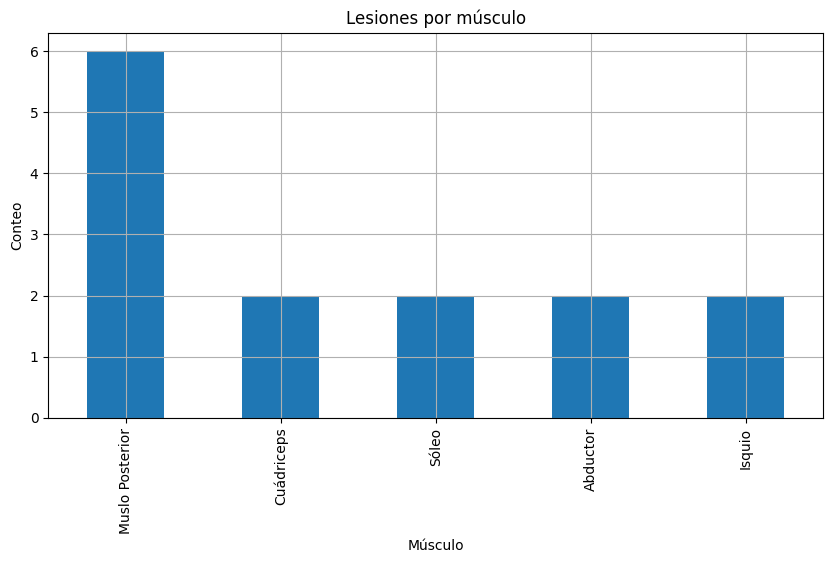

In [5]:

# --- Lesiones por músculo ---
conteo_musculo = df_les['Musculo'].value_counts().sort_values(ascending=False)
fig, ax = plt.subplots()
conteo_musculo.plot(kind='bar', ax=ax)
ax.set_title('Lesiones por músculo')
ax.set_xlabel('Músculo')
ax.set_ylabel('Conteo')
plt.show()


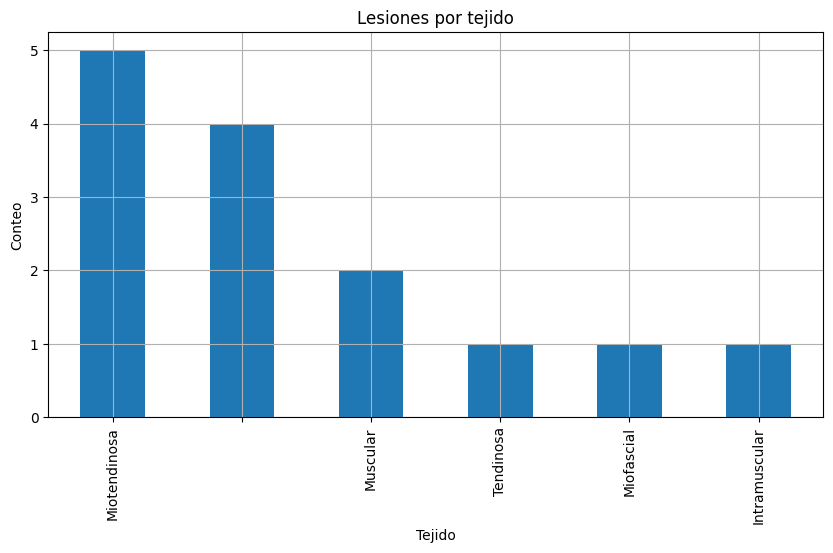

In [6]:

# --- Lesiones por tejido ---
if 'Tejido' in df_les.columns:
    conteo_tejido = df_les['Tejido'].value_counts().sort_values(ascending=False)
    fig, ax = plt.subplots()
    conteo_tejido.plot(kind='bar', ax=ax)
    ax.set_title('Lesiones por tejido')
    ax.set_xlabel('Tejido')
    ax.set_ylabel('Conteo')
    plt.show()


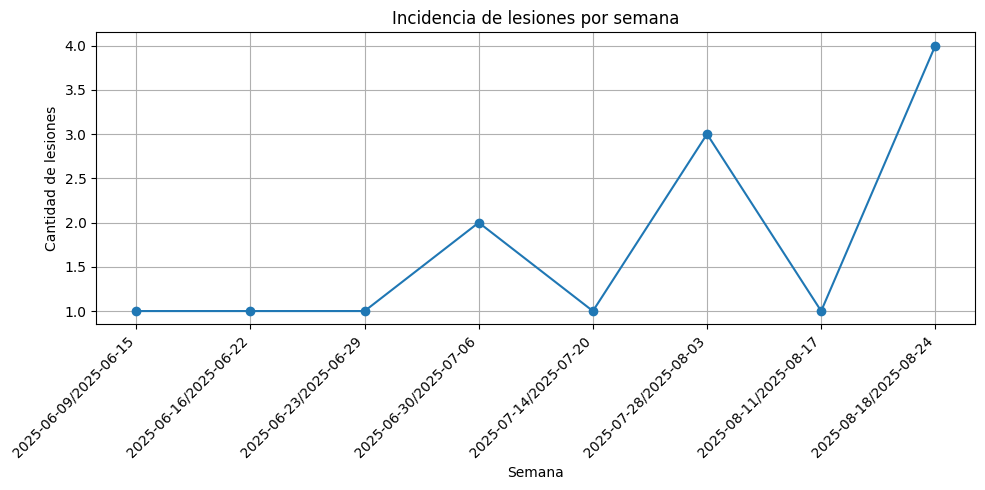

In [7]:

# --- Línea temporal de lesiones (por semana) ---
inc_sem = df_les.groupby('semana').size().reindex(sorted(df_les['semana'].unique()), fill_value=0)
fig, ax = plt.subplots()
inc_sem.plot(kind='line', marker='o', ax=ax)
ax.set_title('Incidencia de lesiones por semana')
ax.set_xlabel('Semana')
ax.set_ylabel('Cantidad de lesiones')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Cargas previas a la lesión (7/14/21 días)

In [12]:

# --- Cruce con cargas previas desde DB_Entrenamientos ---
# Columnas candidatas (acepta variantes)
def pick(colnames, *cands):
    low = {c.lower(): c for c in colnames}
    for c in cands:
        if c in colnames: return c
        if c.lower() in low: return low[c.lower()]
    return None

COL_FECHA_E = pick(df_ent.columns, 'Fecha')
COL_ID_E    = pick(df_ent.columns, 'id_jugador','Id_Jugador','ID_JUGADOR')
COL_CE_E    = pick(df_ent.columns, 'Carga_Explosiva','CE')
COL_CS_E    = pick(df_ent.columns, 'Carga_Sostenida','Carga_Sosotenida','CS')
COL_CR_E    = pick(df_ent.columns, 'Carga_Regenerativa','CR')
COL_REND_E  = pick(df_ent.columns, 'Rendimiento_Diario', 'Rendimiento_Partido')

assert all([COL_FECHA_E, COL_ID_E, COL_CE_E, COL_CS_E, COL_CR_E]), "Faltan columnas de entrenamientos."

df_ent_min = df_ent[[COL_ID_E, COL_FECHA_E, COL_CE_E, COL_CS_E, COL_CR_E] + ([COL_REND_E] if COL_REND_E else [])].copy()
df_ent_min.columns = ['id_jugador','Fecha','CE','CS','CR'] + (['Rend_E'] if COL_REND_E else [])

# Para cada lesión, sumar cargas de los 7/14/21 días previos
records = []
for i, row in df_les.dropna(subset=['id_jugador','Fecha_inicio']).iterrows():
    jid = row['id_jugador']
    fl  = row['Fecha_inicio']
    sub = df_ent_min[(df_ent_min['id_jugador']==jid) & (df_ent_min['Fecha']<fl)]
    win = {
        'CE7' : sub[sub['Fecha'] >= fl - pd.Timedelta(days=7) ]['CE'].sum(),
        'CS7' : sub[sub['Fecha'] >= fl - pd.Timedelta(days=7) ]['CS'].sum(),
        'CR7' : sub[sub['Fecha'] >= fl - pd.Timedelta(days=7) ]['CR'].sum(),
        'CE14': sub[sub['Fecha'] >= fl - pd.Timedelta(days=14)]['CE'].sum(),
        'CS14': sub[sub['Fecha'] >= fl - pd.Timedelta(days=14)]['CS'].sum(),
        'CR14': sub[sub['Fecha'] >= fl - pd.Timedelta(days=14)]['CR'].sum(),
        'CE21': sub[sub['Fecha'] >= fl - pd.Timedelta(days=21)]['CE'].sum(),
        'CS21': sub[sub['Fecha'] >= fl - pd.Timedelta(days=21)]['CS'].sum(),
        'CR21': sub[sub['Fecha'] >= fl - pd.Timedelta(days=21)]['CR'].sum(),
    }
    rec = {
        'id_jugador': jid,
        'Nombre': row.get('Nombre', np.nan),
        'Fecha_inicio': fl,
        'Tipo_lesion': row.get('Tipo_lesion', np.nan),
        'Musculo': row.get('Musculo', np.nan),
        'Lado': row.get('Lado', np.nan),
        'Tejido': row.get('Tejido', np.nan),
    }
    rec.update(win)
    records.append(rec)

df_prev = pd.DataFrame.from_records(records).sort_values('Fecha_inicio')
df_prev


,id_jugador,Nombre,Fecha_inicio,Tipo_lesion,Musculo,Lado,Tejido,CE7,CS7,CR7,CE14,CS14,CR14,CE21,CS21,CR21
0,8,Luis Olivas,2025-06-11,Lesión muscular,Cuádriceps,Derecho,Miotendinosa,3020.0,5092.2,13222.0,5833.2,10126.4,24097.0,7115.6,13186.4,31755.5
1,24,Javier Hernández,2025-06-20,Lesión muscular,Muslo Posterior,Izquierdo,Miotendinosa,2393.5,3250.4,7542.0,4898.3,7834.4,19380.0,5924.7,9057.4,22404.0
2,21,Richard Ledezma,2025-06-25,Sobracarga,Muslo Posterior,Derecho,Muscular,2529.6,4372.4,10748.0,4729.4,7894.0,18421.0,4729.4,7894.0,18421.0
3,9,Diego Campillo,2025-07-03,Sobrecarga,Muslo Posterior,Izquierdo,Muscular,3881.5,4740.2,5189.5,3881.5,4740.2,5189.5,3881.5,4740.2,5189.5
4,6,Miguel Tapias,2025-07-05,Lesión muscular,Muslo Posterior,Izquierdo,Miotendinosa,2401.8,4354.0,8118.5,5326.2,10647.2,20617.0,8151.0,15081.2,29411.5
5,24,Javier Hernández,2025-07-19,Lesión muscular,Sóleo,Izquierdo,Miotendinosa,2477.4,4414.0,9870.0,3696.0,6375.4,14105.0,4175.5,6826.8,14974.0
6,14,Omar Govea,2025-07-30,Lesión muscular,Muslo Posterior,Derecho,Tendinosa,657.3,2371.0,7785.0,1805.5,5514.2,15331.0,3728.5,10360.6,27247.0
7,17,Erick Gutiérrez,2025-08-01,Lesión muscular,Muslo Posterior,Derecho,Miofascial,648.1,1725.8,5139.0,2127.6,5450.6,13091.0,4522.7,11460.8,25475.5
8,21,Richard Ledezma,2025-08-03,Lesión muscular,Cuádriceps,Ambos,Intramuscular,563.4,1542.0,5237.0,2776.4,4914.0,13006.0,5051.8,8652.8,20980.5
9,10,José Castillo,2025-08-16,Lesión muscular,Sóleo,Derecho,Miotendinosa,1559.4,3025.8,7693.0,2101.8,4032.0,10709.5,2885.7,5611.6,14785.0


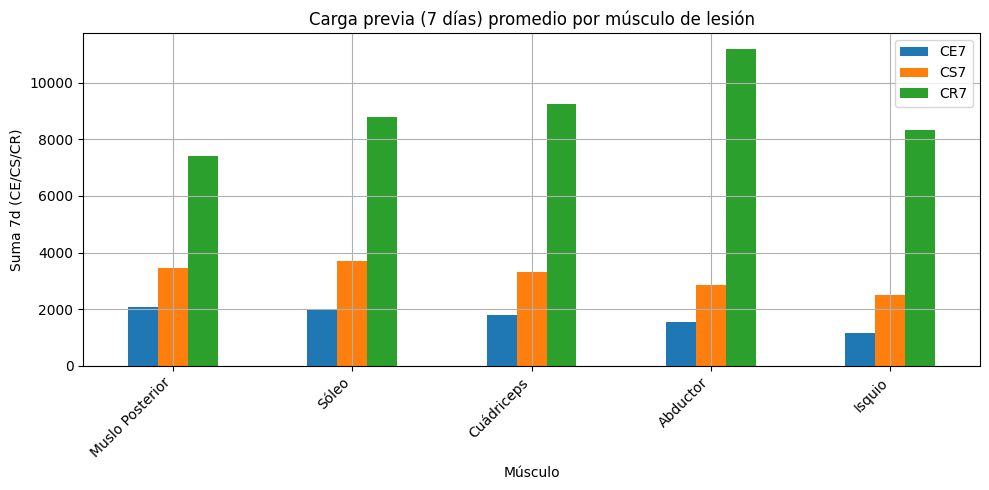

In [13]:

# --- Comparación simple: cargas previas 7d por músculo ---
if not df_prev.empty:
    grp = df_prev.groupby('Musculo')[['CE7','CS7','CR7']].mean().sort_values('CE7', ascending=False)
    fig, ax = plt.subplots()
    grp.plot(kind='bar', ax=ax)
    ax.set_title('Carga previa (7 días) promedio por músculo de lesión')
    ax.set_xlabel('Músculo')
    ax.set_ylabel('Suma 7d (CE/CS/CR)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


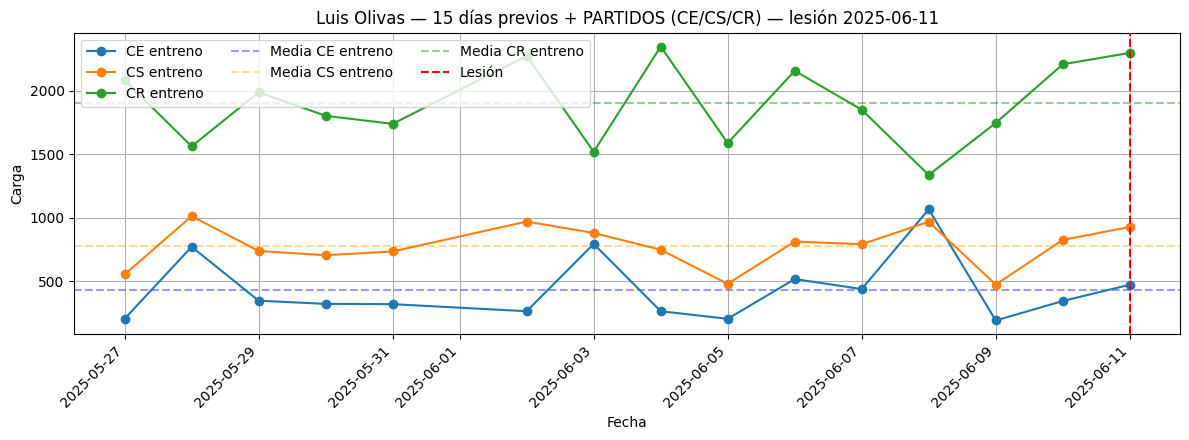

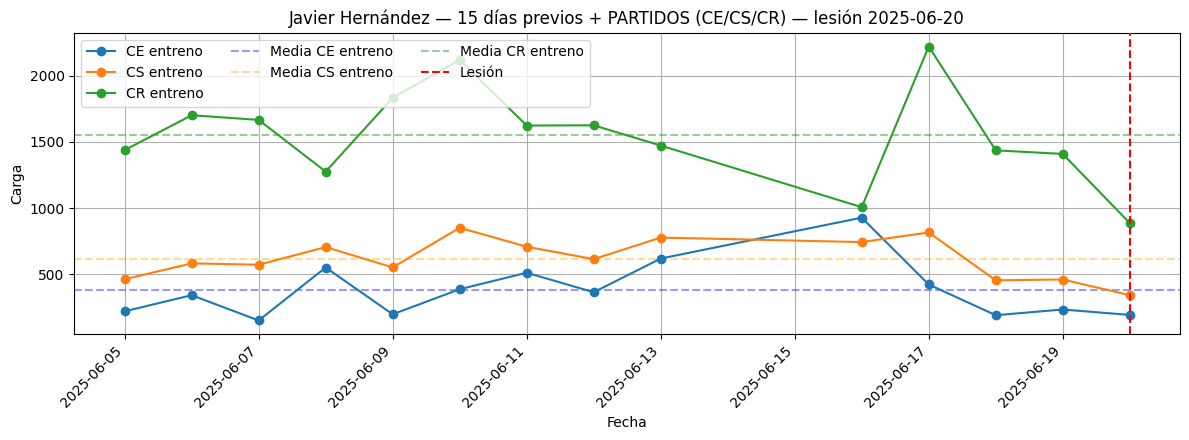

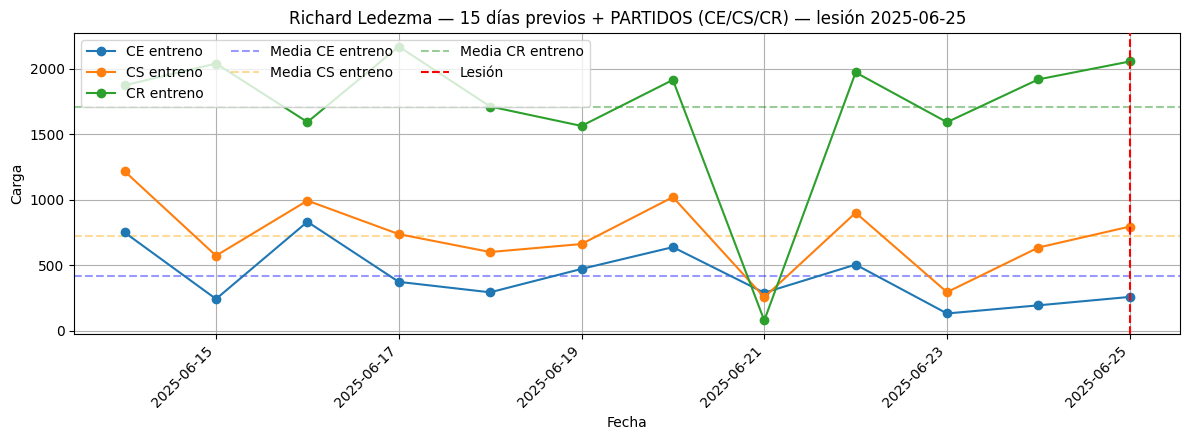

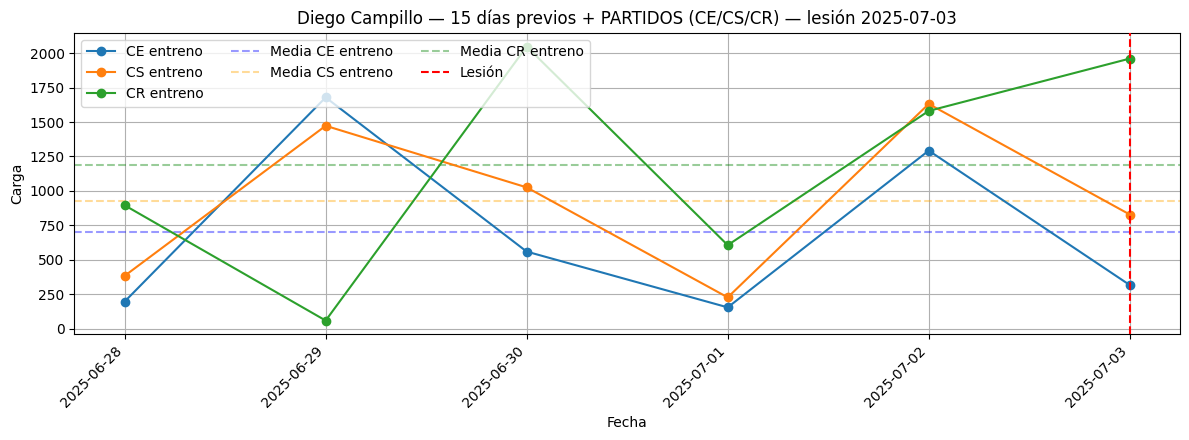

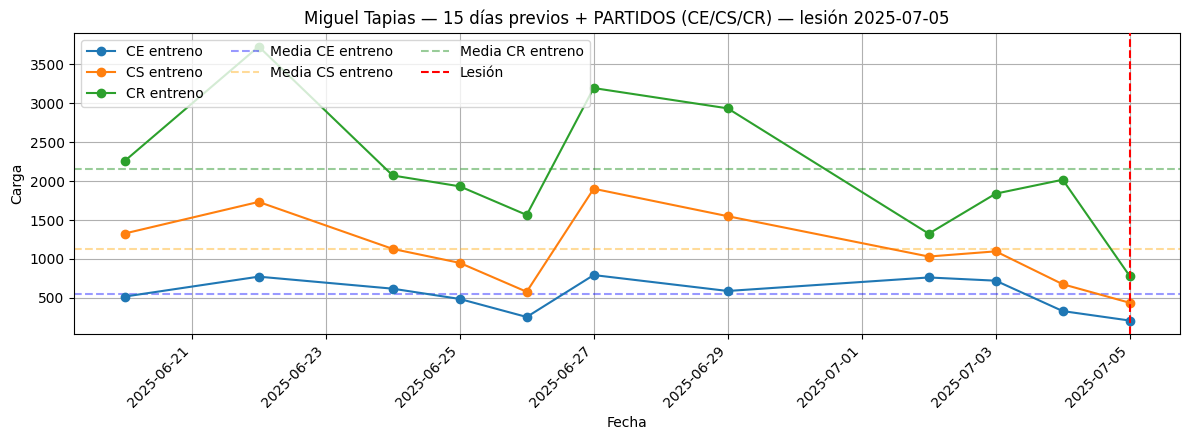

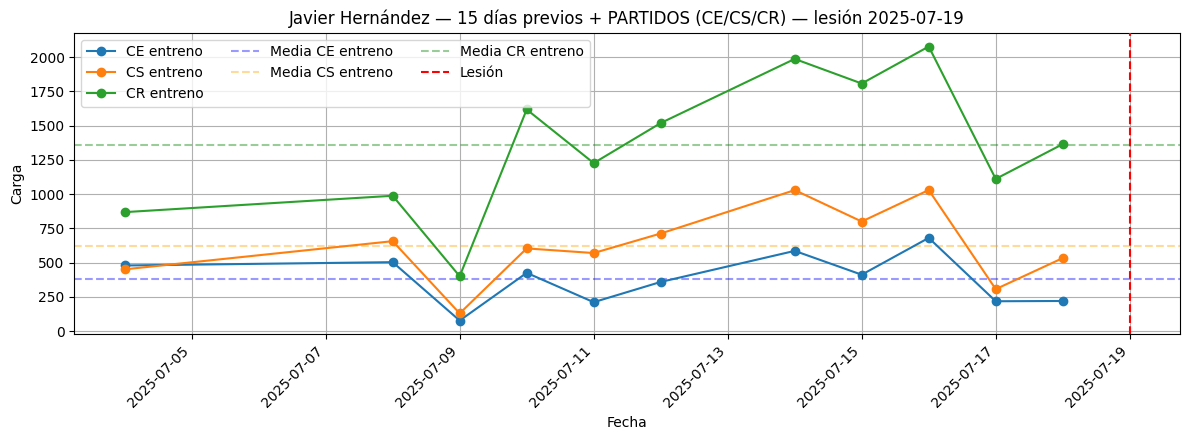

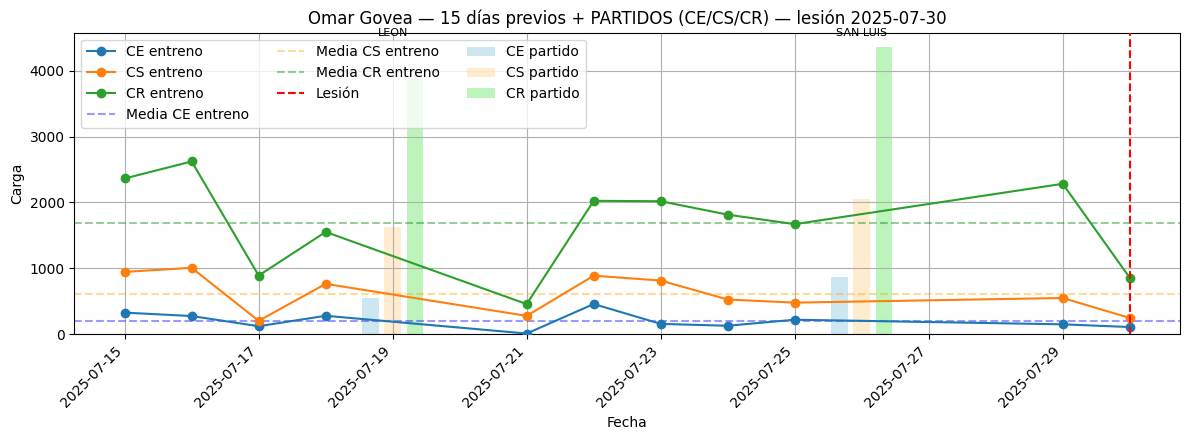

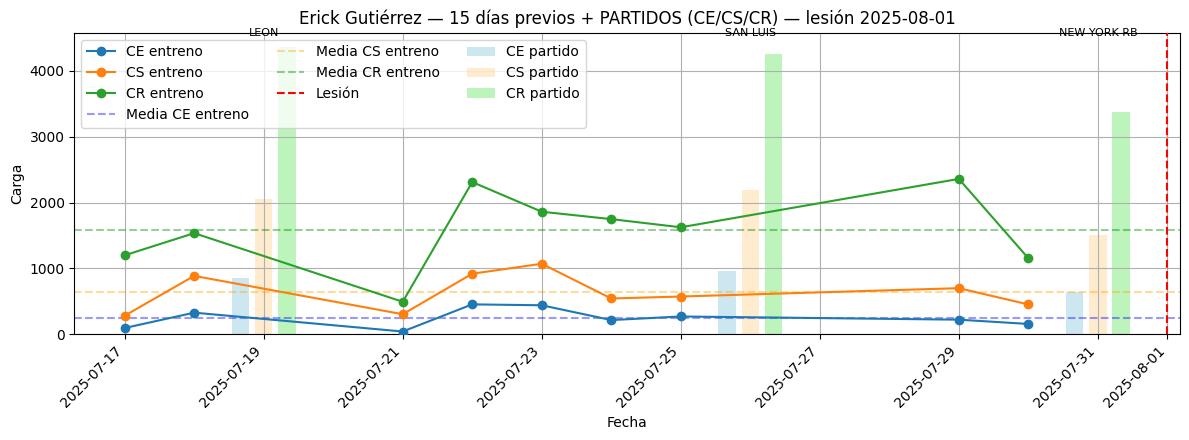

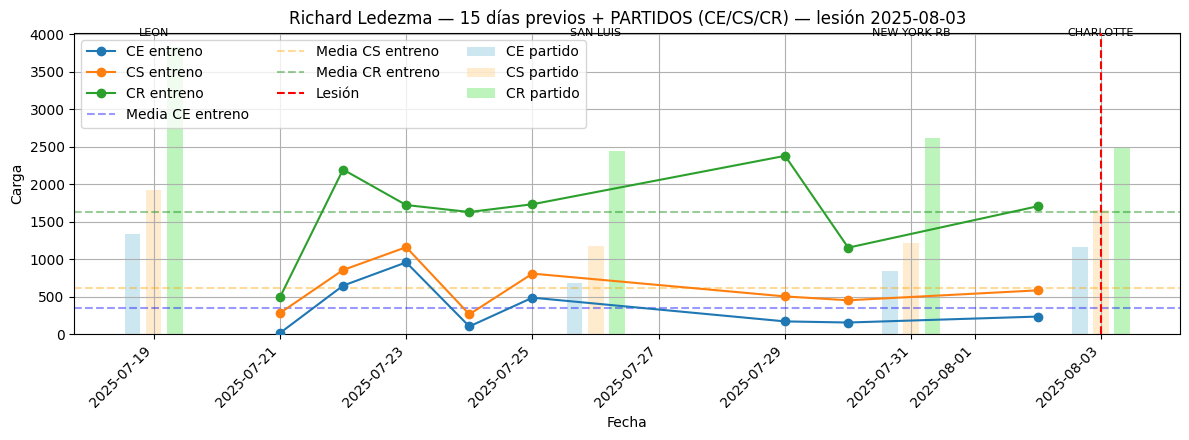

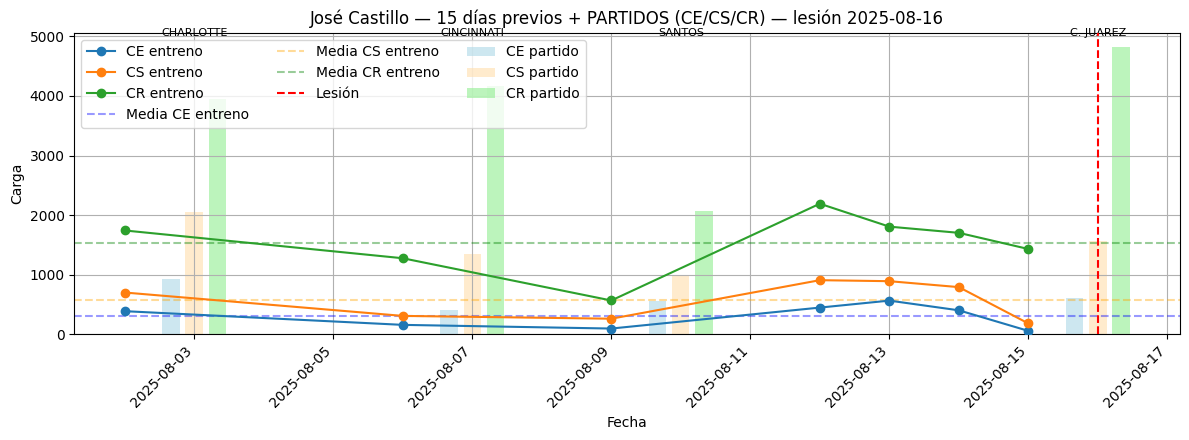

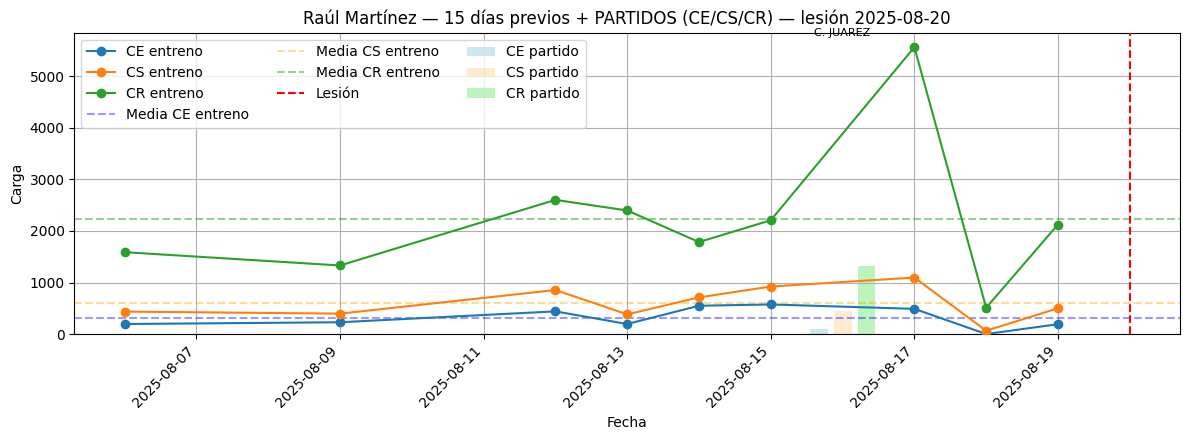

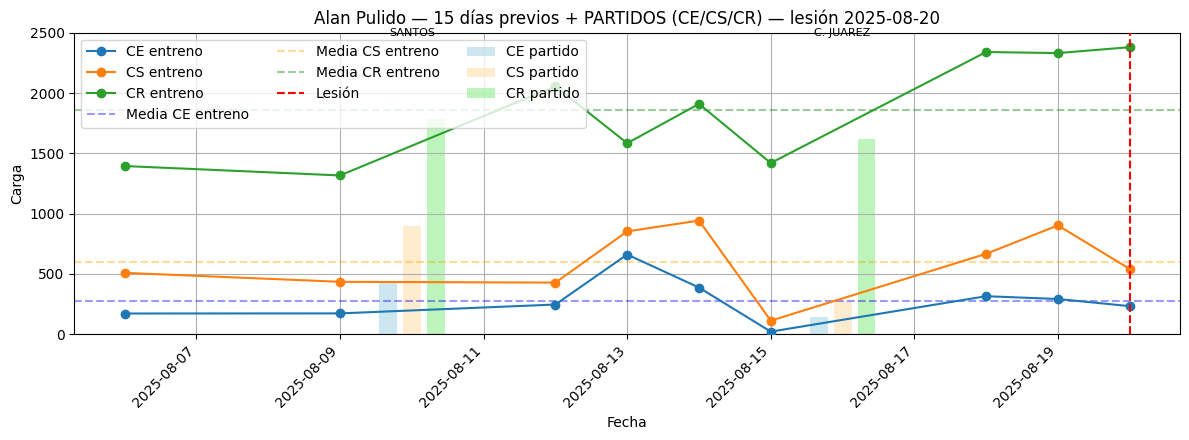

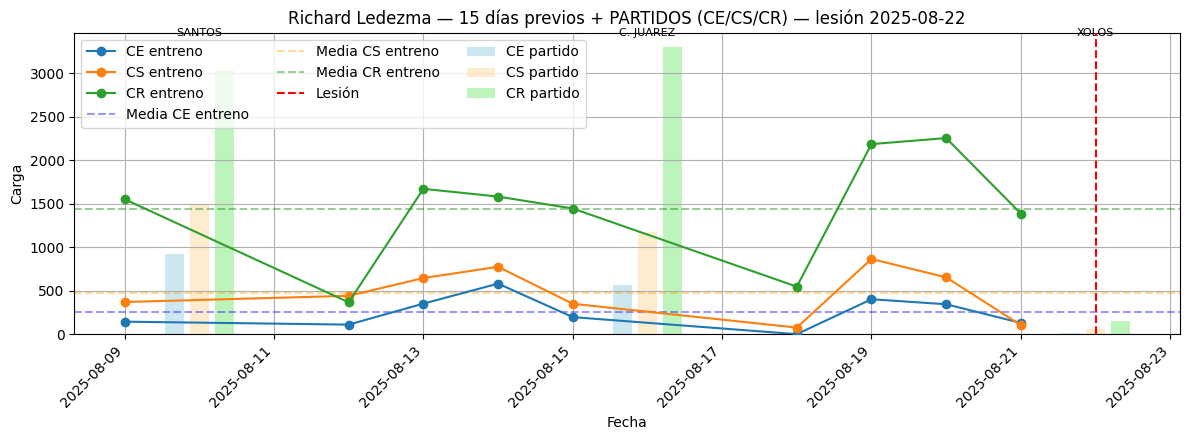

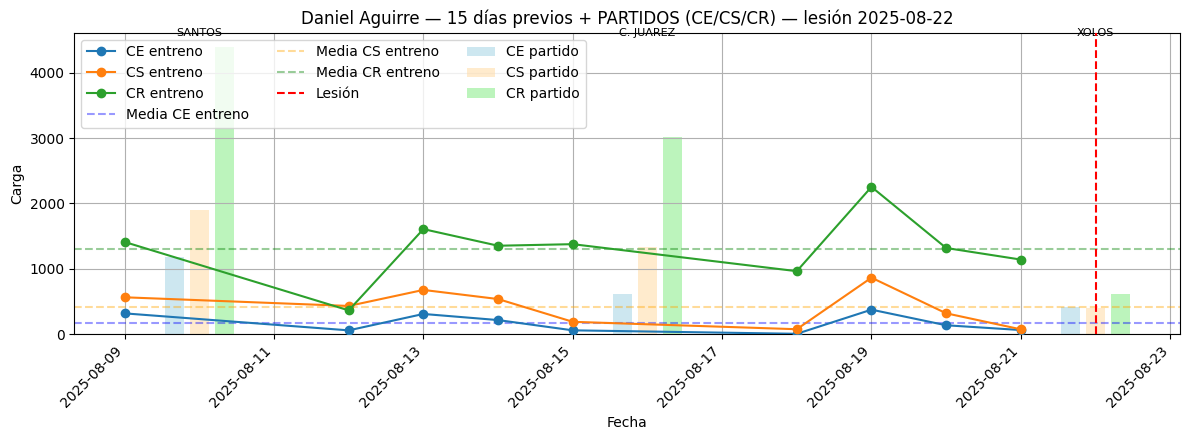

✅ Figuras mostradas: 14 | ⏭️ Omitidas (sin entrenos en ventana): 0


In [36]:
def plot_compuesto_lesion_partido(jid, fecha_lesion, nombre, ventana=15):
    f_ini = fecha_lesion - pd.Timedelta(days=ventana)

    # ENTRENOS (líneas)
    ent = (df_ent_min[(df_ent_min['id_jugador']==jid) &
                      (df_ent_min['Fecha']>=f_ini) &
                      (df_ent_min['Fecha']<=fecha_lesion)]
                      .sort_values('Fecha'))
    if ent.empty:
        print(f"⚠️ Sin entrenos en ventana | {nombre} {fecha_lesion.date()}")
        return False

    # PARTIDOS (barras)
    part = (df_par_min[(df_par_min['id_jugador']==jid) &
                       (df_par_min['Fecha']>=f_ini) &
                       (df_par_min['Fecha']<=fecha_lesion)]
                       .sort_values('Fecha'))

    fig, ax = plt.subplots(figsize=(12,4.5))

    # ----- Líneas de ENTRENOS -----
    ax.plot(ent['Fecha'], ent['CE'], marker='o', label='CE entreno', zorder=3)
    ax.plot(ent['Fecha'], ent['CS'], marker='o', label='CS entreno', zorder=3)
    ax.plot(ent['Fecha'], ent['CR'], marker='o', label='CR entreno', zorder=3)

    # Medias ENTRENOS
    ax.axhline(ent['CE'].mean(), linestyle='--', alpha=0.4, color='blue', label='Media CE entreno')
    ax.axhline(ent['CS'].mean(), linestyle='--', alpha=0.4, color='orange', label='Media CS entreno')
    ax.axhline(ent['CR'].mean(), linestyle='--', alpha=0.4, color='green', label='Media CR entreno')

    # ----- Barras de PARTIDOS -----
    if not part.empty:
        delta = pd.Timedelta(hours=8)
        fechas_ce = part['Fecha'] - delta
        fechas_cs = part['Fecha']
        fechas_cr = part['Fecha'] + delta
        width = pd.Timedelta(hours=6)

        ax.bar(fechas_ce, part['CE_P'].values, width=width, align='center',
               label='CE partido', alpha=0.6, zorder=1, color='lightblue')
        ax.bar(fechas_cs, part['CS_P'].values, width=width, align='center',
               label='CS partido', alpha=0.6, zorder=1, color='navajowhite')
        ax.bar(fechas_cr, part['CR_P'].values, width=width, align='center',
               label='CR partido', alpha=0.6, zorder=1, color='lightgreen')

        # Anotar rivales arriba de la barra central
        if 'Rival' in part.columns:
            y_text = max(ent[['CE','CS','CR']].max().max(),
                         part[['CE_P','CS_P','CR_P']].max().max()) * 1.03
            for f, rv in zip(part['Fecha'], part['Rival']):
                ax.annotate(str(rv), (f, y_text), xytext=(0, 2), textcoords='offset points',
                            ha='center', fontsize=8, rotation=0)

    # Línea vertical de lesión
    ax.axvline(fecha_lesion, linestyle='--', linewidth=1.5, color='red', label='Lesión', zorder=4)

    ax.set_title(f"{nombre} — {ventana} días previos + PARTIDOS (CE/CS/CR) — lesión {fecha_lesion.date()}")
    ax.set_xlabel("Fecha"); ax.set_ylabel("Carga")
    ax.legend(loc='upper left', ncol=3)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout(); plt.show()
    return True


# ---------- Ejecutar para cada lesión (mostrará la compuesta; incluirá partidos si existieron) ----------
dib, skip = 0, 0
for _, row in df_les.dropna(subset=['id_jugador','Fecha_inicio']).iterrows():
    ok = plot_compuesto_lesion_partido(
        jid=row['id_jugador'],
        fecha_lesion=row['Fecha_inicio'],
        nombre=row.get('Nombre', f"Jugador {row['id_jugador']}"),
        ventana=15
    )
    dib += int(ok); skip += int(not ok)

print(f"✅ Figuras mostradas: {dib} | ⏭️ Omitidas (sin entrenos en ventana): {skip}")


In [18]:
# === Saneo rápido: (re)crear df_eq, df_les_dia y df_part_eq ===
import pandas as pd
import numpy as np

def pick(cols, *cands):
    low = {c.lower(): c for c in cols}
    for c in cands:
        if c in cols: return c
        if c.lower() in low: return low[c.lower()]
    return None

# --- Asegurar dataframes base ya cargados ---
assert 'df_ent' in globals(), "Falta df_ent"
assert 'df_les' in globals(), "Falta df_les"
assert 'df_par' in globals(), "Falta df_par"  # si no usás partidos, podés comentar esta línea

# --- Fechas / tipos ---
for _df in (df_ent, df_par):
    if 'Fecha' in _df.columns:
        _df['Fecha'] = pd.to_datetime(_df['Fecha'], errors='coerce')
if 'Fecha_inicio' in df_les.columns:
    df_les['Fecha_inicio'] = pd.to_datetime(df_les['Fecha_inicio'], errors='coerce')

# --- df_eq: promedio diario de ENTRENOS ---
COL_REND_E = pick(df_ent.columns, 'Rendimiento_Diario', 'Rendimiento_Partido')
assert COL_REND_E is not None, "No encuentro Rendimiento_Diario en df_ent"
df_eq = (df_ent.dropna(subset=['Fecha', COL_REND_E])
               .groupby('Fecha', as_index=False)[COL_REND_E].mean()
               .rename(columns={COL_REND_E:'Rend_eq'}))

# --- df_les_dia: cantidad de lesiones por día ---
df_les_dia = (df_les.dropna(subset=['Fecha_inicio'])
                    .groupby('Fecha_inicio', as_index=False)
                    .size()
                    .rename(columns={'Fecha_inicio':'Fecha','size':'n_lesiones'}))

# --- (opcional) df_part_eq: rendimiento promedio por fecha de PARTIDO ---
COL_REND_P = pick(df_par.columns, 'Rendimiento_Partido')
if COL_REND_P is not None and 'Fecha' in df_par.columns:
    df_part_eq = (df_par.dropna(subset=['Fecha', COL_REND_P])
                         .groupby('Fecha', as_index=False)[COL_REND_P].mean()
                         .rename(columns={COL_REND_P:'Rend_part_eq'}))
else:
    df_part_eq = pd.DataFrame(columns=['Fecha','Rend_part_eq'])

print("df_eq:", df_eq.shape, " | df_les_dia:", df_les_dia.shape, " | df_part_eq:", df_part_eq.shape)
display(df_eq.head(3), df_les_dia.head(3), df_part_eq.head(3))


df_eq: (80, 2)  | df_les_dia: (12, 2)  | df_part_eq: (9, 2)


,Fecha,Rend_eq
0,2025-05-19,7.565781
1,2025-05-23,4.563182
2,2025-05-24,18.244792


,Fecha,n_lesiones
0,2025-06-11,1
1,2025-06-20,1
2,2025-06-25,1


,Fecha,Rend_part_eq
0,2025-07-19,71.064821
1,2025-07-26,74.621851
2,2025-07-31,73.886927


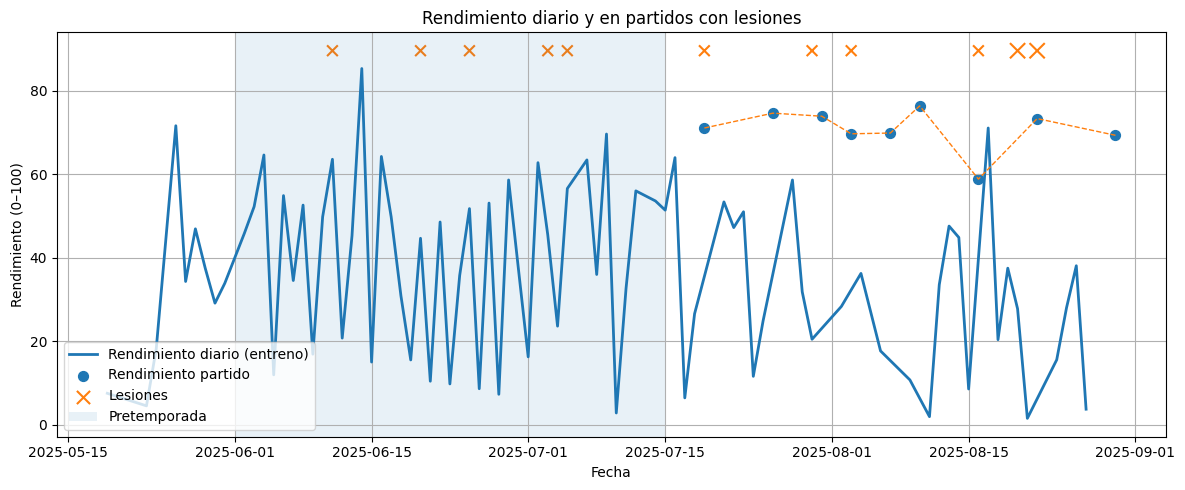

In [22]:
# --- Preparación igual que antes (df_eq, df_part_eq, df_les_dia ya creados) ---

# Promedio por FECHA de PARTIDO (0-100)
COL_REND_P = pick(df_par.columns, 'Rendimiento_Partido')
df_part_eq = (df_par.dropna(subset=['Fecha', COL_REND_P])
                     .groupby('Fecha', as_index=False)[COL_REND_P]
                     .mean()
                     .rename(columns={'Fecha':'Fecha','Rendimiento_Partido':'Rend_part_eq'}))

# Merge sólo para ubicar lesiones y ordenar fechas
df_plot = (df_eq.merge(df_part_eq, on='Fecha', how='outer')
                .merge(df_les_dia, on='Fecha', how='left')
                .sort_values('Fecha'))
df_plot['n_lesiones'] = df_plot['n_lesiones'].fillna(0)

fig, ax = plt.subplots(figsize=(12,5))

# 1) ENTRENOS: ploteá desde df_eq (sin NaNs -> no se corta)
ax.plot(df_eq['Fecha'], df_eq['Rend_eq'], linewidth=2, label='Rendimiento diario (entreno)')

# 2) PARTIDOS: puntos + línea punteada opcional
mask_p = df_part_eq['Rend_part_eq'].notna()
ax.scatter(df_part_eq.loc[mask_p,'Fecha'], df_part_eq.loc[mask_p,'Rend_part_eq'],
           s=50, marker='o', label='Rendimiento partido')
ax.plot(df_part_eq.loc[mask_p,'Fecha'], df_part_eq.loc[mask_p,'Rend_part_eq'],
        linestyle='--', linewidth=1)

# 3) Lesiones (cruces) arriba
y_top = float(max(df_eq['Rend_eq'].max(),
                  df_part_eq['Rend_part_eq'].max() if not df_part_eq.empty else 0)) * 1.05
mask_l = df_plot['n_lesiones'] > 0
ax.scatter(df_plot.loc[mask_l,'Fecha'], [y_top]*int(mask_l.sum()),
           s=60*df_plot.loc[mask_l,'n_lesiones'], marker='x', label='Lesiones')

# 4) Sombreado de pretemporada (mismo que la 1ª)
PRETEMPORADA = ('2025-06-01','2025-07-15')  # ajustá si querés
f0, f1 = pd.to_datetime(PRETEMPORADA[0]), pd.to_datetime(PRETEMPORADA[1])
ax.axvspan(f0, f1, alpha=0.1, label='Pretemporada')

ax.set_xlabel('Fecha'); ax.set_ylabel('Rendimiento (0–100)')
ax.set_title('Rendimiento diario y en partidos con lesiones')
ax.legend(loc='lower left')
plt.tight_layout(); plt.show()




## Reincidencias por jugador

In [21]:

reinc_table = (df_les
    .sort_values(['id_jugador','Fecha_inicio'])
    .groupby(['id_jugador','Nombre'])
    .agg(
        lesiones=('id_lesion','count'),
        primera_lesion=('Fecha_inicio','min'),
        ultima_lesion=('Fecha_inicio','max'),
        min_dias_entre_lesiones=('dias_desde_lesion_previa', 'min')
    )
    .reset_index()
    .sort_values(['lesiones','ultima_lesion'], ascending=[False, True])
)
reinc_table.head(20)


,id_jugador,Nombre,lesiones,primera_lesion,ultima_lesion,min_dias_entre_lesiones
8,21,Richard Ledezma,3,2025-06-25,2025-08-22,19.0
10,24,Javier Hernández,2,2025-06-20,2025-07-19,29.0
1,8,Luis Olivas,1,2025-06-11,2025-06-11,NaN
2,9,Diego Campillo,1,2025-07-03,2025-07-03,NaN
0,6,Miguel Tapias,1,2025-07-05,2025-07-05,NaN
5,14,Omar Govea,1,2025-07-30,2025-07-30,NaN
6,17,Erick Gutiérrez,1,2025-08-01,2025-08-01,NaN
3,10,José Castillo,1,2025-08-16,2025-08-16,NaN
4,13,Raúl Martínez,1,2025-08-20,2025-08-20,NaN
9,23,Alan Pulido,1,2025-08-20,2025-08-20,NaN


In [ ]:

#conn.close()
#print("Listo ✔️")
